## Table of contents

* [Utility Function](#utility)
* [Data Generator](#generator)
* [Train EDA](#tr_eda)
* [Models](#models)
    * [Metrics](#metrics)
    * [Predict](#predict)
* [Error EDA 1](#eda1)
* [Error EDA 2](#eda2)
* [Prediction EDA](#pred_eda)
   

In [2]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"
import numpy as np

import keras._tf_keras.keras
from keras._tf_keras.keras.models import load_model
from keras._tf_keras.keras import backend as K
from segmentation_models import Unet
from segmentation_models import  get_preprocessing
import tensorflow as tf

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from dataclasses import dataclass
import warnings
warnings.filterwarnings('ignore')

In [5]:
if tf.config.list_physical_devices()[1]:
   print("Tensorflow is using a GPU.")
else:
   print("Tensorflow is not using a GPU.")

Tensorflow is using a GPU.


In [3]:
@dataclass
class G:
    BACKBONE = 'resnet50'
    preprocess_input = get_preprocessing(BACKBONE)
    path = os.path.join(os.getcwd(), 'data')
    model_path = os.path.join(os.getcwd(), 'models/unet.keras')
    train = pd.read_csv(path + '/train.csv')

In [4]:
train2 = G.train.pivot(index='ImageId', columns='ClassId', 
                     values='EncodedPixels')
train2.fillna('',inplace=True); 
train2['count'] = np.sum(train2.iloc[:]!='',axis=1).values
train2 = pd.DataFrame(train2.to_records())
train2.rename(columns={"1":"e1","2":"e2","3":"e3","4":"e4"}, inplace=True)
train2.head()

ImageId                                                 e1 e2  \
0  0002cc93b.jpg  29102 12 29346 24 29602 24 29858 24 30114 24 3...      
1  0007a71bf.jpg                                                         
2  000a4bcdd.jpg  37607 3 37858 8 38108 14 38359 20 38610 25 388...      
3  000f6bf48.jpg                                                         
4  0014fce06.jpg                                                         

                                                  e3  \
0                                                      
1  18661 28 18863 82 19091 110 19347 110 19603 11...   
2                                                      
3                                                      
4  229501 11 229741 33 229981 55 230221 77 230468...   

                                                  e4  count  
0                                                         1  
1                                                         1  
2                                                         1  
3  131973 1 132228 4 132483 6 132738 8 132993 11 ...      1  
4                                                         1

### Utility Function <a class="anchor" id="utility"></a>

In [5]:
def rle2maskResize(rle):
    # CONVERT RLE TO MASK 
    if (pd.isnull(rle))|(rle==''): 
        return np.zeros((128,800) ,dtype=np.uint8)
    
    height= 256
    width = 1600
    mask= np.zeros( width*height ,dtype=np.uint8)

    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]-1
    lengths = array[1::2]    
    for index, start in enumerate(starts):
        mask[int(start):int(start+lengths[index])] = 1
    
    return mask.reshape( (height,width), order='F' )[::2,::2]

def mask2contour(mask, width=3):
    # CONVERT MASK TO ITS CONTOUR
    w = mask.shape[1]
    h = mask.shape[0]
    mask2 = np.concatenate([mask[:,width:],np.zeros((h,width))],axis=1)
    mask2 = np.logical_xor(mask,mask2)
    mask3 = np.concatenate([mask[width:,:],np.zeros((width,w))],axis=0)
    mask3 = np.logical_xor(mask,mask3)
    return np.logical_or(mask2,mask3) 

def mask2pad(mask, pad=2):
    # ENLARGE MASK TO INCLUDE MORE SPACE AROUND DEFECT
    w = mask.shape[1]
    h = mask.shape[0]
    
    # MASK UP
    for k in range(1,pad,2):
        temp = np.concatenate([mask[k:,:],np.zeros((k,w))],axis=0)
        mask = np.logical_or(mask,temp)
    # MASK DOWN
    for k in range(1,pad,2):
        temp = np.concatenate([np.zeros((k,w)),mask[:-k,:]],axis=0)
        mask = np.logical_or(mask,temp)
    # MASK LEFT
    for k in range(1,pad,2):
        temp = np.concatenate([mask[:,k:],np.zeros((h,k))],axis=1)
        mask = np.logical_or(mask,temp)
    # MASK RIGHT
    for k in range(1,pad,2):
        temp = np.concatenate([np.zeros((h,k)),mask[:,:-k]],axis=1)
        mask = np.logical_or(mask,temp)
    
    return mask

### Data Generator <a class="anchor" id="generator"></a>

In [6]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, df, batch_size = 16, subset="train", shuffle=False, 
                 preprocess=None, info={}):
        super().__init__()
        self.df = df
        self.shuffle = shuffle
        self.subset = subset
        self.batch_size = batch_size
        self.preprocess = preprocess
        self.info = info
        
        if self.subset == "train":
            self.data_path = G.path + '/train_images/'
        elif self.subset == "test":
            self.data_path = G.path + '/test_images/'
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.df) / self.batch_size))
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.df))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    def __getitem__(self, index): 
        X = np.empty((self.batch_size,128,800,3),dtype=np.float32)
        y = np.empty((self.batch_size,128,800,4),dtype=np.int8)
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        for i,f in enumerate(self.df['ImageId'].iloc[indexes]):
            self.info[index*self.batch_size+i]=f
            X[i,] = Image.open(self.data_path + f).resize((800,128))
            if self.subset == 'train': 
                for j in range(4):
                    y[i,:,:,j] = rle2maskResize(self.df['e'+str(j+1)].iloc[indexes[i]])
        if self.preprocess!=None: X = self.preprocess(X)
        if self.subset == 'train': return X, y
        else: return (X,)

### Train EDA <a class="anchor" id="tr_eda"></a>

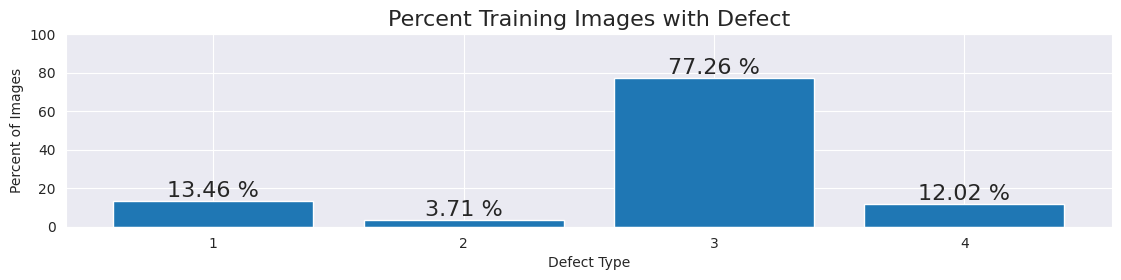

In [7]:
plt.figure(figsize=(13.5,2.5))
bar = plt.bar( [1,2,3,4],100*np.mean( train2.iloc[:,1:5]!='',axis=0))
plt.title('Percent Training Images with Defect', fontsize=16)
plt.ylabel('Percent of Images'); plt.xlabel('Defect Type')
plt.xticks([1,2,3,4])
for rect in bar:    
    height = rect.get_height()    
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%.2f %%' % height,
             ha='center', va='bottom',fontsize=16)
plt.ylim((0,100)); plt.show()

Images and masks from our Data Generator
KEY: yellow=defect1, green=defect2, blue=defect3, magenta=defect4


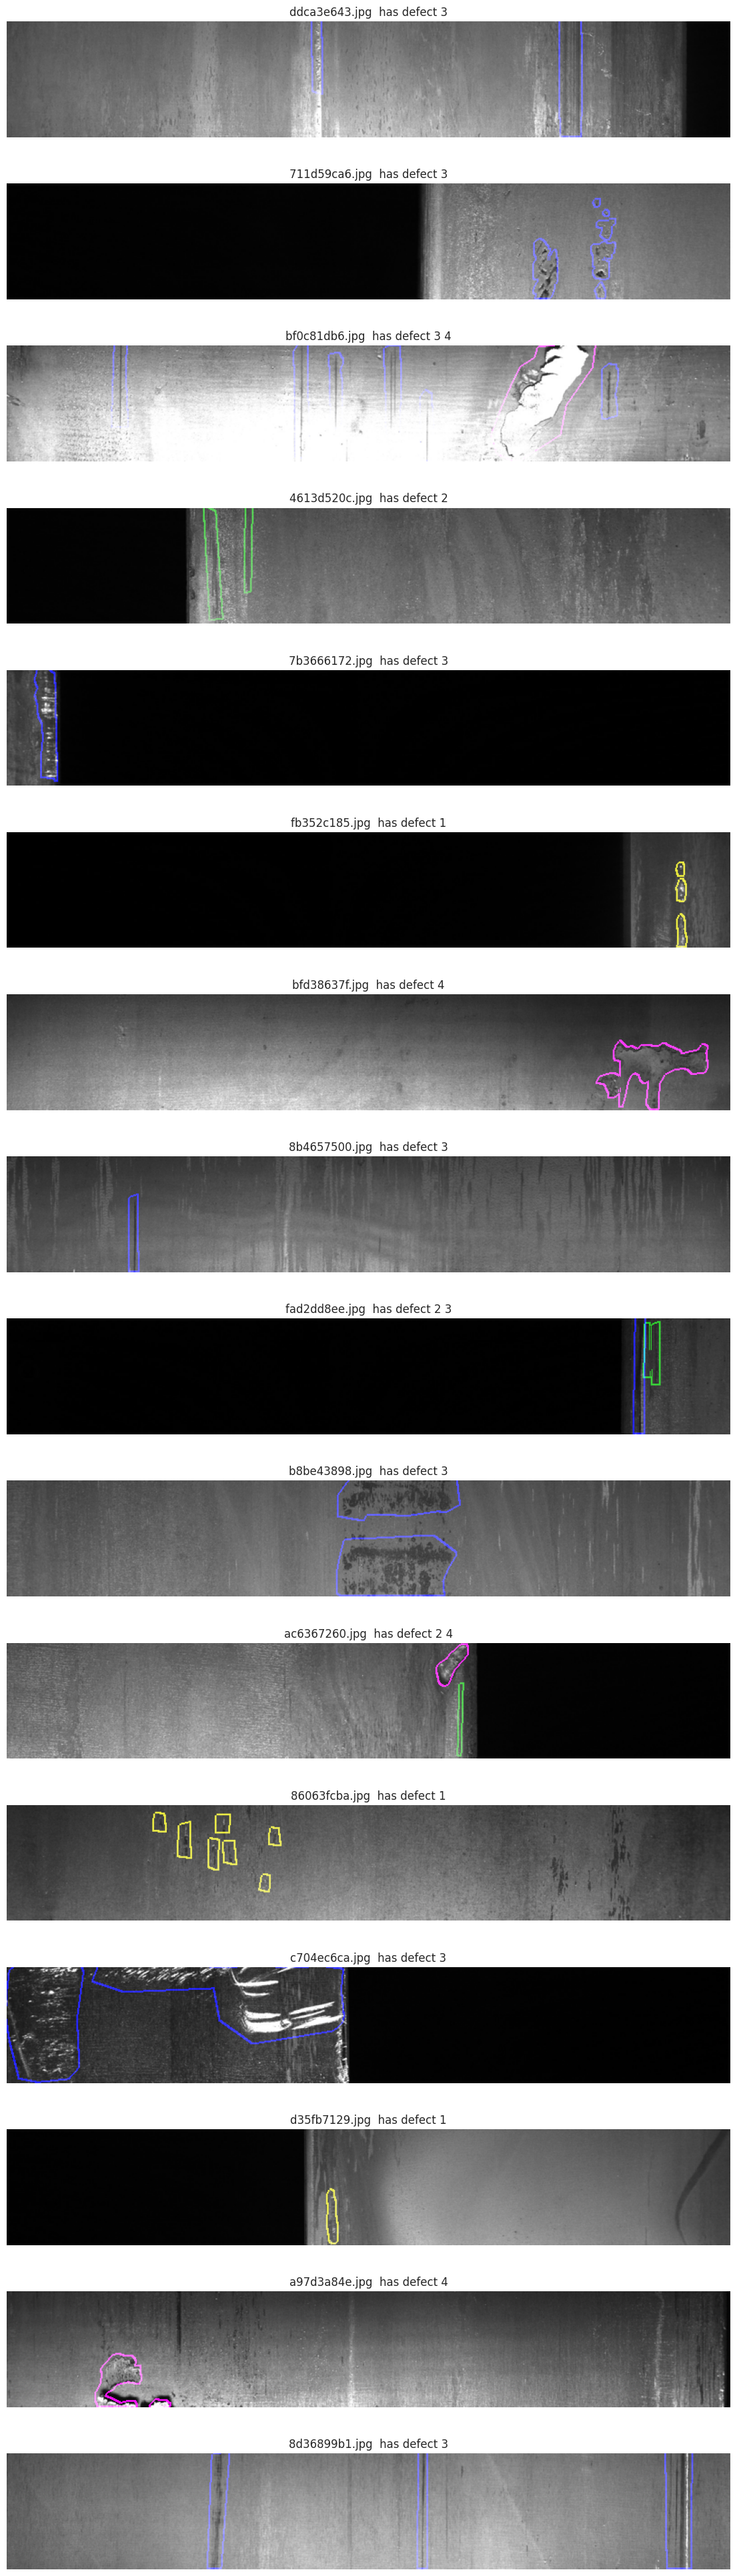

In [8]:
# DEFECTIVE IMAGE SAMPLES
filenames = {}
defects = list(train2[train2['e1']!=''].sample(3).index)
defects += list(train2[train2['e2']!=''].sample(3).index)
defects += list(train2[train2['e3']!=''].sample(7).index)
defects += list(train2[train2['e4']!=''].sample(3).index)

# DATA GENERATOR
train_batches = DataGenerator(train2[train2.index.isin(defects)],shuffle=True,info=filenames)
print('Images and masks from our Data Generator')
print('KEY: yellow=defect1, green=defect2, blue=defect3, magenta=defect4')

# DISPLAY IMAGES WITH DEFECTS
for i,batch in enumerate(train_batches):
    if i != 0: break
    plt.figure(figsize=(14,50)) #20,18
    for k in range(16):
        plt.subplot(16,1,k+1)
        img = batch[0][k,]
        img = Image.fromarray(img.astype('uint8'))
        img = np.array(img)
        extra = '  has defect'
        for j in range(4):
            msk = batch[1][k,:,:,j]
            msk = mask2pad(msk,pad=3)
            msk = mask2contour(msk,width=2)
            if np.sum(msk)!=0: extra += ' '+str(j+1)
            if j==0: # yellow
                img[msk==1,0] = 235 
                img[msk==1,1] = 235
            elif j==1: img[msk==1,1] = 210 # green
            elif j==2: img[msk==1,2] = 255 # blue
            elif j==3: # magenta
                img[msk==1,0] = 255
                img[msk==1,2] = 255
        plt.title(filenames[16*i+k]+extra)
        plt.axis('off') 
        plt.imshow(img)
    plt.subplots_adjust(wspace=0.05)
    plt.show()

### Model <a class="anchor" id="models"></a>

In [9]:
# COMPETITION METRIC
def dice_coef(y_true, y_pred, smooth=1):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [10]:
# LOAD UNET WITH PRETRAINING FROM IMAGENET
model = Unet(G.BACKBONE, encoder_weights='imagenet',input_shape=(128, 800, 3), classes=4, 
             activation='sigmoid')
model.compile(optimizer='adam', loss='binary_crossentropy', 
              metrics=[dice_coef])

2024-11-13 08:28:14.243275: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7195 MB memory:  -> device: 0, name: Quadro P4000, pci bus id: 0000:01:00.0, compute capability: 6.1


In [11]:
# TRAIN AND VALIDATE MODEL
idx = int(0.8*len(train2)); 
train_batches = DataGenerator(train2.iloc[:idx],shuffle=True,
                              preprocess=G.preprocess_input)
valid_batches = DataGenerator(train2.iloc[idx:],preprocess=G.preprocess_input)
history = model.fit(train_batches, validation_data = valid_batches, epochs 
= 100, verbose=2)

Epoch 1/100


I0000 00:00:1731482929.598501   12691 service.cc:145] XLA service 0x76597c003bd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731482929.598531   12691 service.cc:153]   StreamExecutor device (0): Quadro P4000, Compute Capability 6.1
2024-11-13 08:28:50.438192: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-13 08:28:53.684628: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8903
2024-11-13 08:28:56.740483: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 8.58GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-11-13 08:28:57.348305: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GP

333/333 - 289s - 867ms/step - dice_coef: 0.1999 - loss: 0.1000 - val_dice_coef: 0.2070 - val_loss: 0.0753
Epoch 2/100
333/333 - 208s - 625ms/step - dice_coef: 0.3783 - loss: 0.0345 - val_dice_coef: 0.2066 - val_loss: 0.1613
Epoch 3/100
333/333 - 203s - 611ms/step - dice_coef: 0.4465 - loss: 0.0304 - val_dice_coef: 0.4727 - val_loss: 0.0298
Epoch 4/100
333/333 - 203s - 610ms/step - dice_coef: 0.4781 - loss: 0.0285 - val_dice_coef: 0.3351 - val_loss: 0.0573
Epoch 5/100
333/333 - 203s - 610ms/step - dice_coef: 0.5086 - loss: 0.0267 - val_dice_coef: 0.4305 - val_loss: 0.0334
Epoch 6/100
333/333 - 203s - 610ms/step - dice_coef: 0.5264 - loss: 0.0253 - val_dice_coef: 0.5593 - val_loss: 0.0254
Epoch 7/100
333/333 - 204s - 611ms/step - dice_coef: 0.5377 - loss: 0.0249 - val_dice_coef: 0.5634 - val_loss: 0.0255
Epoch 8/100
333/333 - 203s - 611ms/step - dice_coef: 0.5512 - loss: 0.0237 - val_dice_coef: 0.5384 - val_loss: 0.0260
Epoch 9/100
333/333 - 203s - 610ms/step - dice_coef: 0.5653 - loss: 

### Metrics <a class="anchor" id="metrics"></a>

The way to evaluate a predictions. The  *dice score*. Recall that:
$$Dice Score = 2 * \frac{area\_of\_overlap}{combined\_area}$$
The plot below does that :

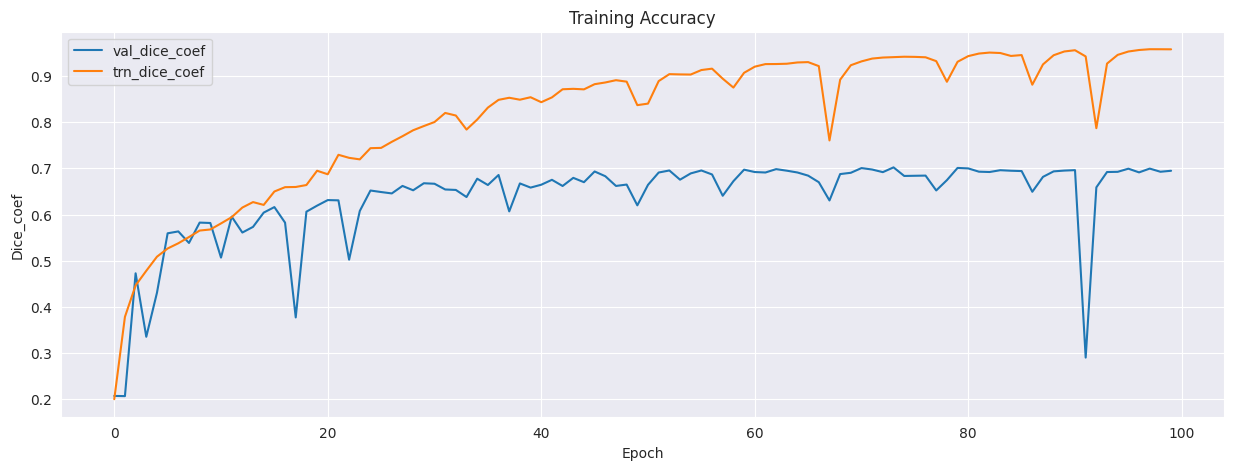

In [12]:
# PLOT TRAINING
plt.figure(figsize=(15,5))
plt.plot(range(history.epoch[-1]+1),history.history['val_dice_coef'],label='val_dice_coef')
plt.plot(range(history.epoch[-1]+1),history.history['dice_coef'],label='trn_dice_coef')
plt.title('Training Accuracy'); plt.xlabel('Epoch'); plt.ylabel('Dice_coef');plt.legend(); 
plt.show()

In [13]:
 
val_set = train2.iloc[idx:]
defects = list(val_set[val_set['e1']!=''].sample(6).index)
defects += list(val_set[val_set['e2']!=''].sample(6).index)
defects += list(val_set[val_set['e3']!=''].sample(14).index)
defects += list(val_set[val_set['e4']!=''].sample(6).index)

valid_batches = DataGenerator(val_set[val_set.index.isin(defects)],
                              preprocess=G.preprocess_input)
preds = model.predict(valid_batches,verbose=1)

2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step


2024-11-13 14:17:53.900746: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 52428800 exceeds 10% of free system memory.


### Predict <a class="anchor" id="predict"></a>

Plotting predictions...
KEY: yellow=defect1, green=defect2, blue=defect3, magenta=defect4


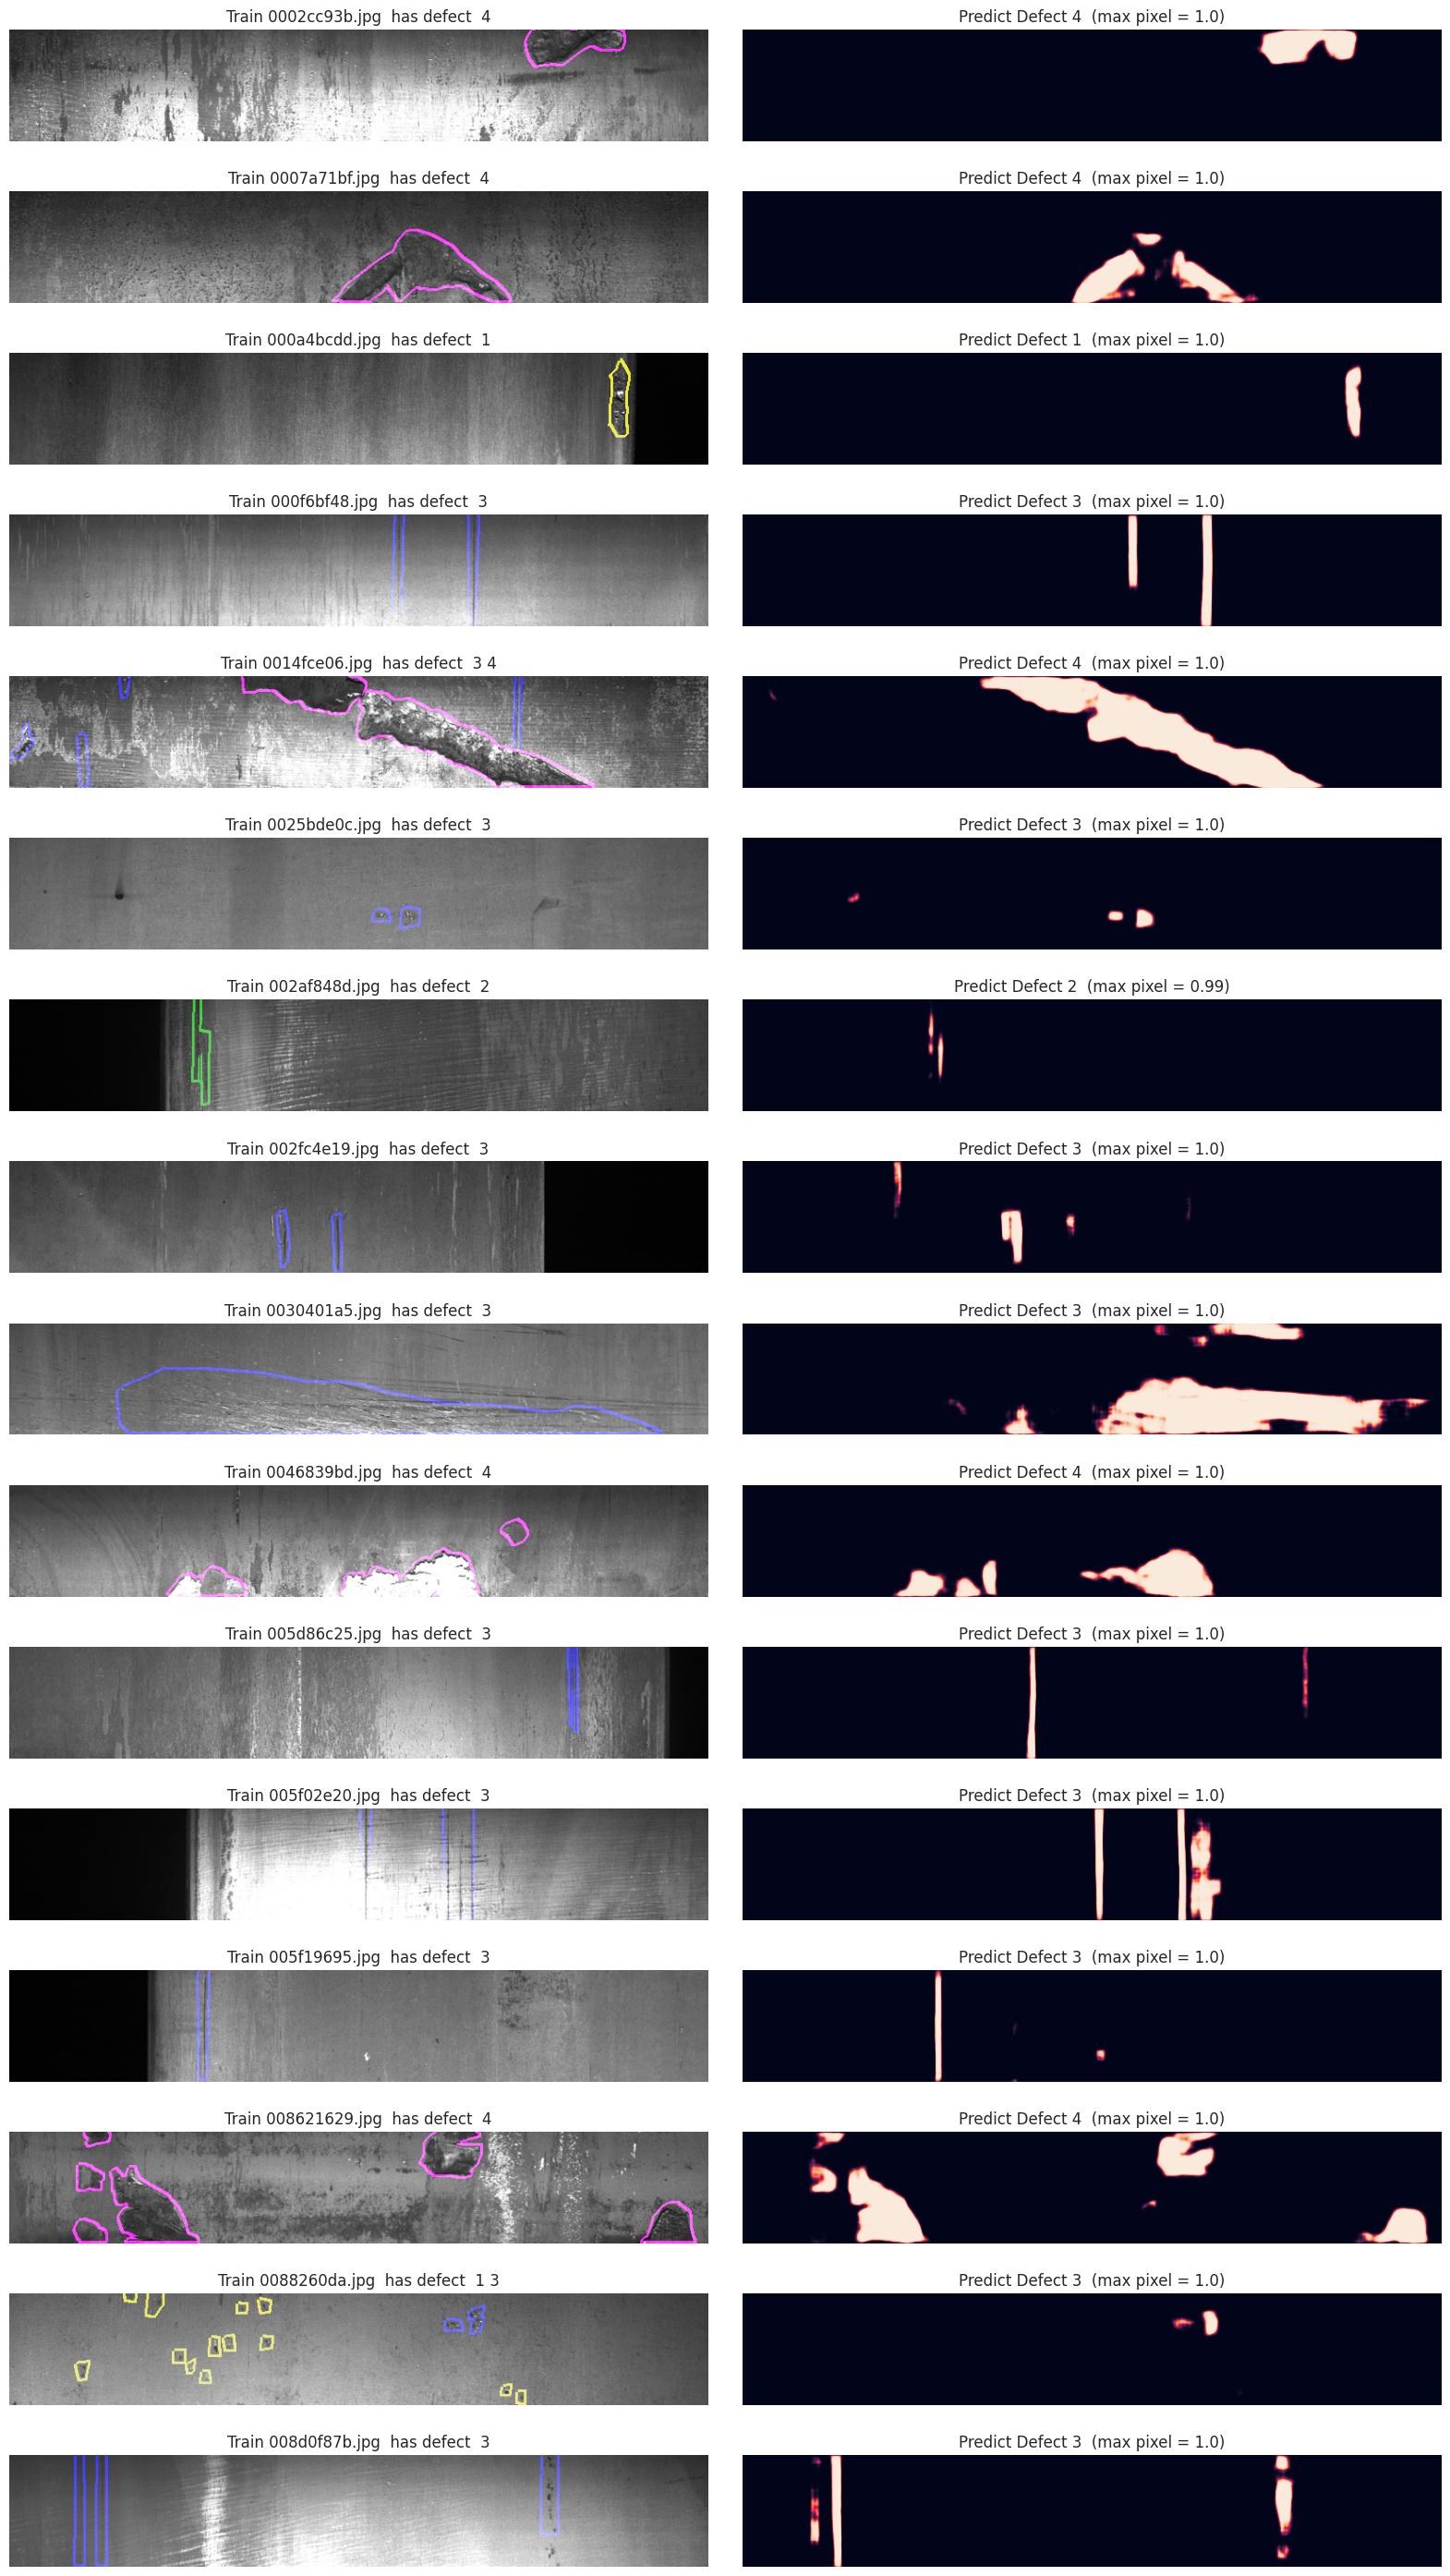

In [14]:
# PLOT PREDICTIONS
valid_batches = DataGenerator(val_set[val_set.index.isin(defects)])
print('Plotting predictions...')
print('KEY: yellow=defect1, green=defect2, blue=defect3, magenta=defect4')

for i,batch in enumerate(valid_batches):
    if i != 0: break
    plt.figure(figsize=(20,36))
    for k in range(16):
        plt.subplot(16,2,2*k+1)
        img = batch[0][k,]
        img = Image.fromarray(img.astype('uint8'))
        img = np.array(img)
        dft = 0
        extra = '  has defect '
        for j in range(4):
            msk = batch[1][k,:,:,j]
            if np.sum(msk)!=0: 
                dft=j+1
                extra += ' '+str(j+1)
            msk = mask2pad(msk,pad=2)
            msk = mask2contour(msk,width=3)
            if j==0: # yellow
                img[msk==1,0] = 235 
                img[msk==1,1] = 235
            elif j==1: img[msk==1,1] = 210 # green
            elif j==2: img[msk==1,2] = 255 # blue
            elif j==3: # magenta
                img[msk==1,0] = 255
                img[msk==1,2] = 255
        if extra=='  has defect ': extra =''
        plt.title('Train '+train2.iloc[16*i+k,0]+extra)
        plt.axis('off') 
        plt.imshow(img)
        plt.subplot(16,2,2*k+2) 
        if dft!=0:
            msk = preds[i+k,:,:,dft-1]
            plt.imshow(msk)
        else:
            plt.imshow(np.zeros((128,800)))
        plt.axis('off')
        mx = np.round(np.max(msk),3)
        plt.title('Predict Defect '+str(dft)+'  (max pixel = '+str(mx)+')')
    plt.subplots_adjust(wspace=0.05)
    plt.show()

### Error EDA 1 <a class="anchor" id="eda1"></a>
#### Below, regardless of what type of defect an image has, we will plot the 
#### defect 3 mask. Only the blue contour lines on the left are defect 3. So 
#### when we see contours on the left that do not include blue, we should not 
#### see defect 3 masks but we still do.

In [15]:
# PREDICT FROM VALIDATION SET (ONLY IMAGES WITH DEFECTS 1, 2, 4)
val_set = train2.iloc[idx:]
val_set2 = val_set[(val_set['count']!=0)&(val_set['e3']=='')].sample(16)

valid_batches = DataGenerator(val_set2,preprocess=G.preprocess_input)
preds = model.predict(valid_batches,verbose=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Plotting predictions...
KEY: yellow=defect1, green=defect2, blue=defect3, magenta=defect4


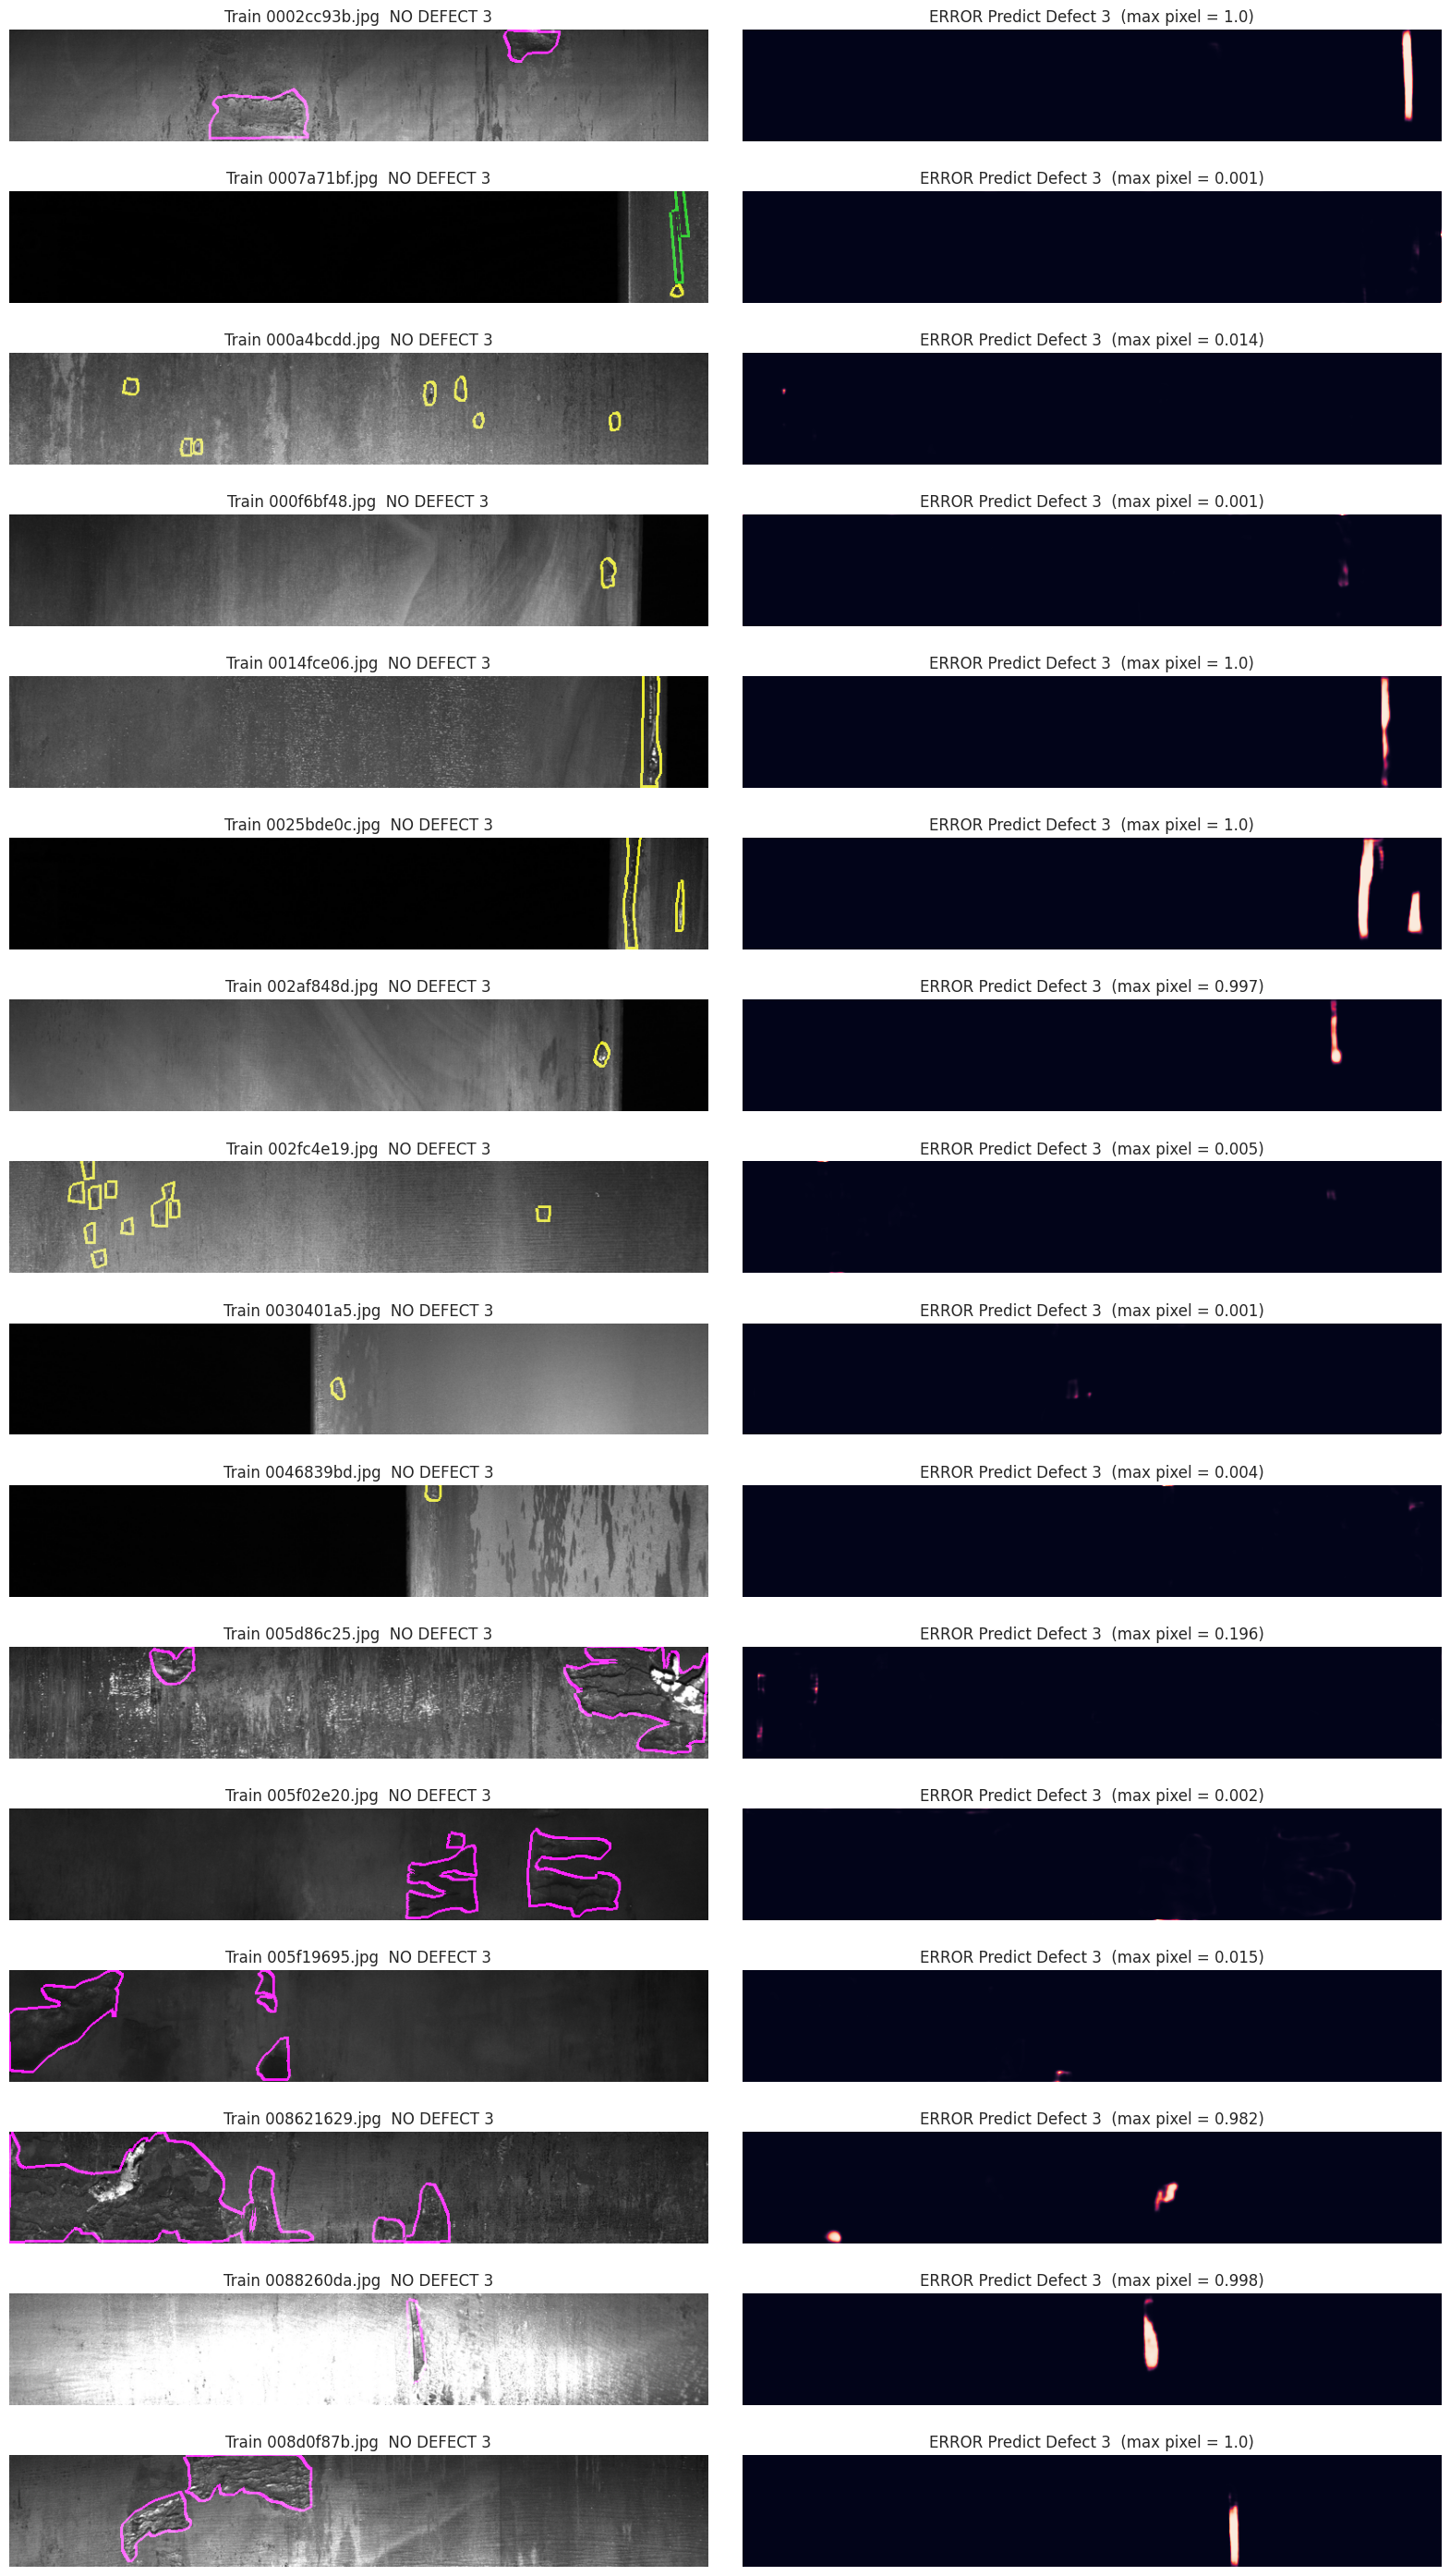

In [16]:
# PLOT PREDICTIONS
valid_batches = DataGenerator(val_set2)
print('Plotting predictions...')
print('KEY: yellow=defect1, green=defect2, blue=defect3, magenta=defect4')
for i,batch in enumerate(valid_batches):
    if i != 0: break
    plt.figure(figsize=(20,36))
    for k in range(16):
        plt.subplot(16,2,2*k+1)
        img = batch[0][k,]
        img = Image.fromarray(img.astype('uint8'))
        img = np.array(img)
        dft = 0
        three = False
        for j in range(4):
            msk = batch[1][k,:,:,j]
            if (j==2)&(np.sum(msk)!=0): 
                three=np.sum(msk)
            msk = mask2pad(msk,pad=2)
            msk = mask2contour(msk,width=3)
            if j==0: # yellow
                img[msk==1,0] = 235 
                img[msk==1,1] = 235
            elif j==1: img[msk==1,1] = 210 # green
            elif j==2: img[msk==1,2] = 255 # blue
            elif j==3: # magenta
                img[msk==1,0] = 255
                img[msk==1,2] = 255
        extra = ''; extra2 = ''
        if not three: 
            extra = 'NO DEFECT 3'
            extra2 = 'ERROR '
        plt.title('Train '+train2.iloc[16*i+k,0]+'  '+extra)
        plt.axis('off') 
        plt.imshow(img)
        plt.subplot(16,2,2*k+2) 
        dft=3
        if dft!=0:
            msk = preds[16*i+k,:,:,dft-1]
            plt.imshow(msk)
        else:
            plt.imshow(np.zeros((128,800)))
        plt.axis('off')
        mx = np.round(np.max(msk),3)
        plt.title(extra2+'Predict Defect '+str(dft)+'  (max pixel = '+str(mx)+')')
    plt.subplots_adjust(wspace=0.05)
    plt.show()

### Error EDA 2 <a class="anchor" id="eda2"></a>
#### When UNET predicts a mask when a defect isn't present, we call that an 
#### "incorrect" mask. When UNET predicts a mask when a defect is present, we 
#### call that a "correct" mask. If UNET predicts less than 250 pixels, we 
#### will treat that as no mask predicted. Let's compare the distribution of 
#### "incorrect" versus "correct" masks for each defect type.

In [17]:
# PREDICT FROM VALIDATION SET (USE ALL)
valid_batches = DataGenerator(train2.iloc[idx:],preprocess=G.preprocess_input)
preds = model.predict(valid_batches,verbose=1)

83/83 ━━━━━━━━━━━━━━━━━━━━ 12s 145ms/step


2024-11-13 14:19:00.665752: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2175795200 exceeds 10% of free system memory.


######################################
## Threshold = 0.1 displayed below ##
######################################


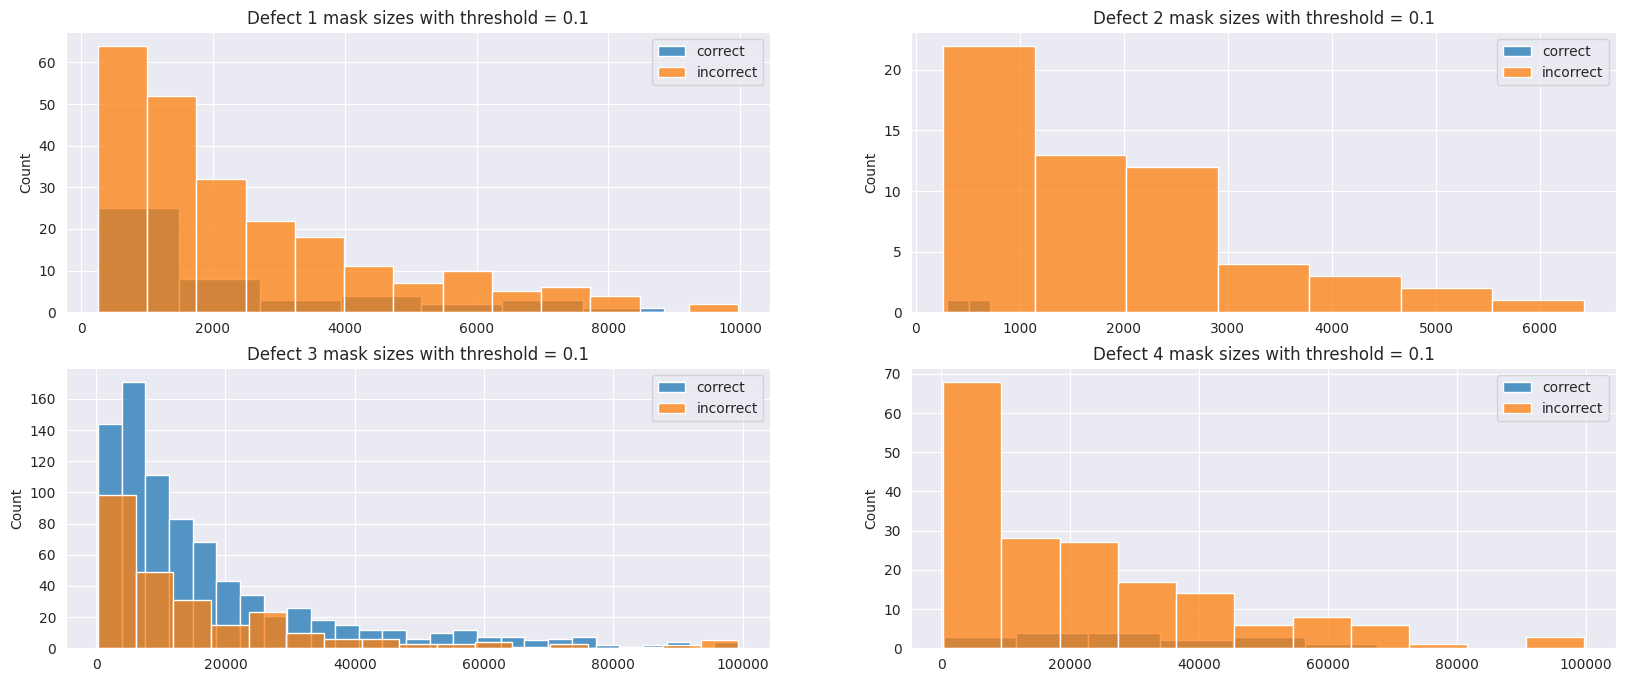

With threshold = 0.1 , defect 1 has 48 correct and 247 incorrect masks
With threshold = 0.1 , defect 2 has 2 correct and 57 incorrect masks
With threshold = 0.1 , defect 3 has 853 correct and 266 incorrect masks
With threshold = 0.1 , defect 4 has 18 correct and 184 incorrect masks

######################################
## Threshold = 0.25 displayed below ##
######################################


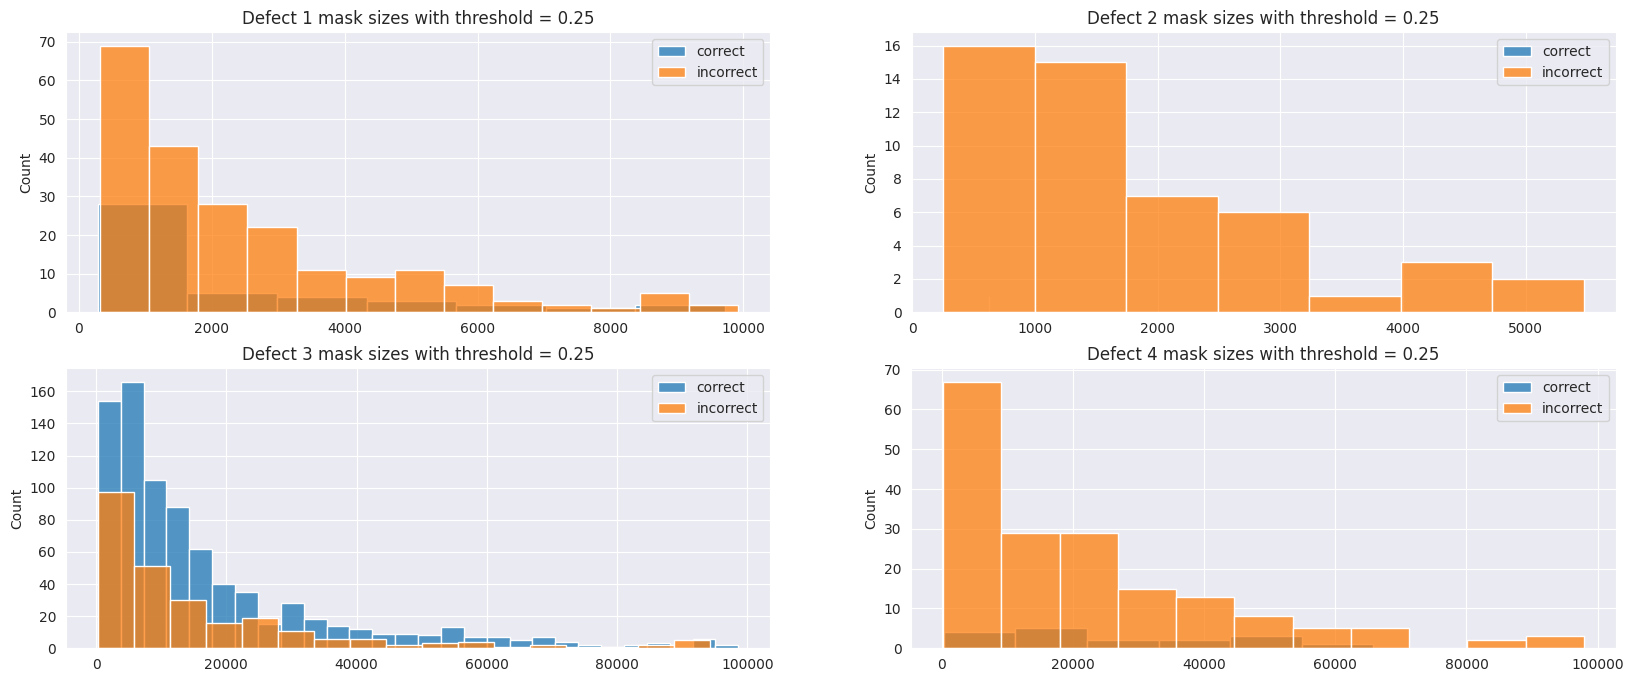

With threshold = 0.25 , defect 1 has 45 correct and 221 incorrect masks
With threshold = 0.25 , defect 2 has 1 correct and 50 incorrect masks
With threshold = 0.25 , defect 3 has 840 correct and 263 incorrect masks
With threshold = 0.25 , defect 4 has 18 correct and 180 incorrect masks

######################################
## Threshold = 0.5 displayed below ##
######################################


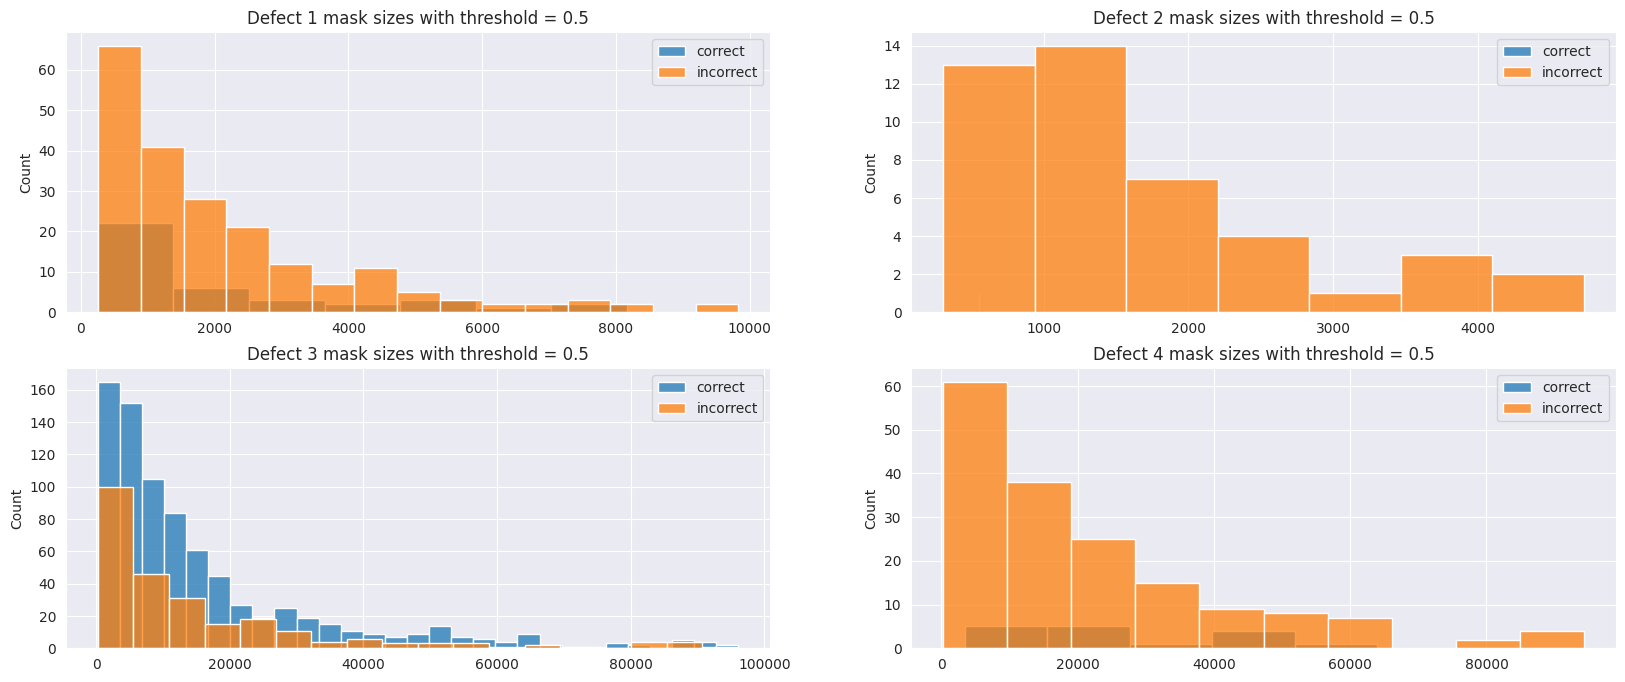

With threshold = 0.5 , defect 1 has 39 correct and 211 incorrect masks
With threshold = 0.5 , defect 2 has 1 correct and 44 incorrect masks
With threshold = 0.5 , defect 3 has 829 correct and 258 incorrect masks
With threshold = 0.5 , defect 4 has 17 correct and 172 incorrect masks

######################################
## Threshold = 0.75 displayed below ##
######################################


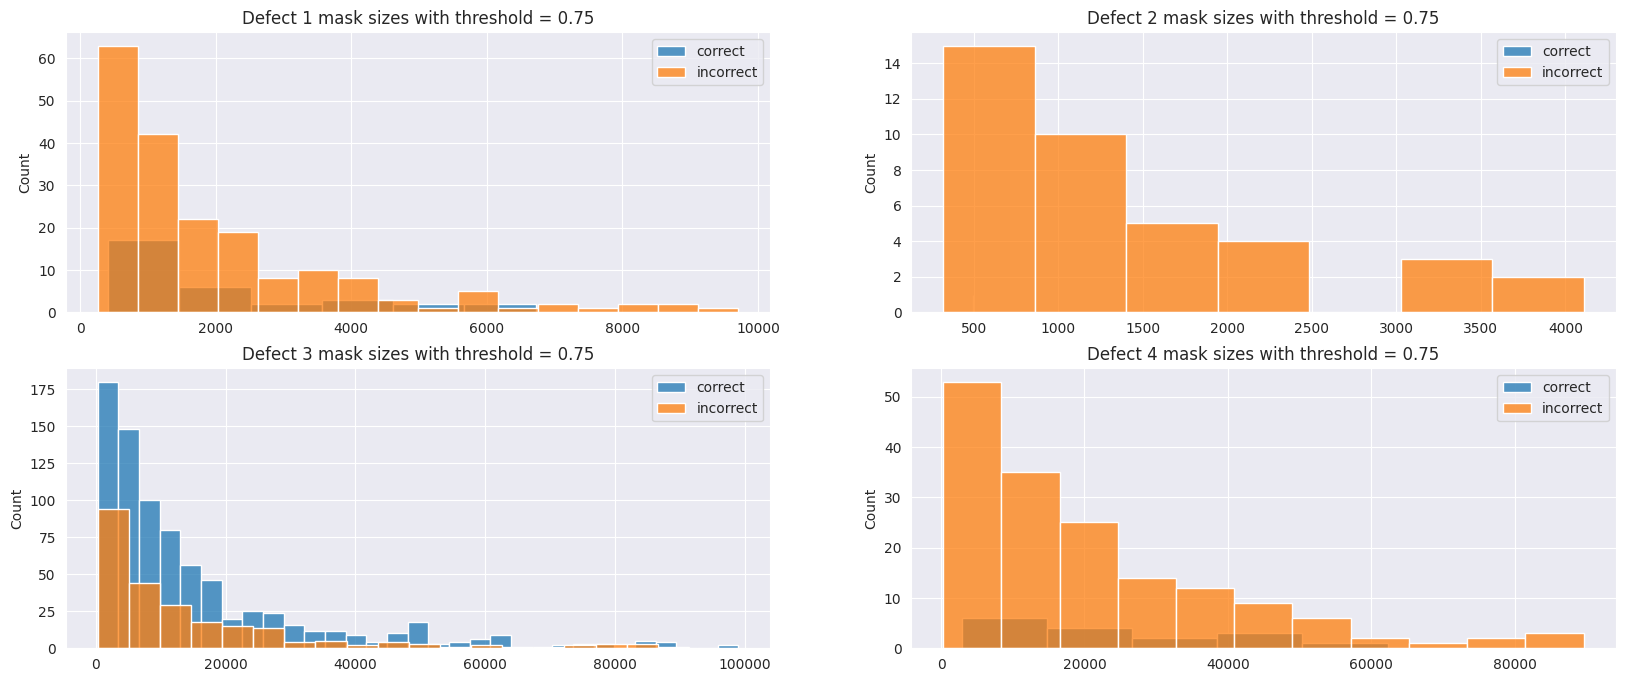

With threshold = 0.75 , defect 1 has 32 correct and 192 incorrect masks
With threshold = 0.75 , defect 2 has 1 correct and 39 incorrect masks
With threshold = 0.75 , defect 3 has 815 correct and 251 incorrect masks
With threshold = 0.75 , defect 4 has 17 correct and 165 incorrect masks

######################################
## Threshold = 0.9 displayed below ##
######################################


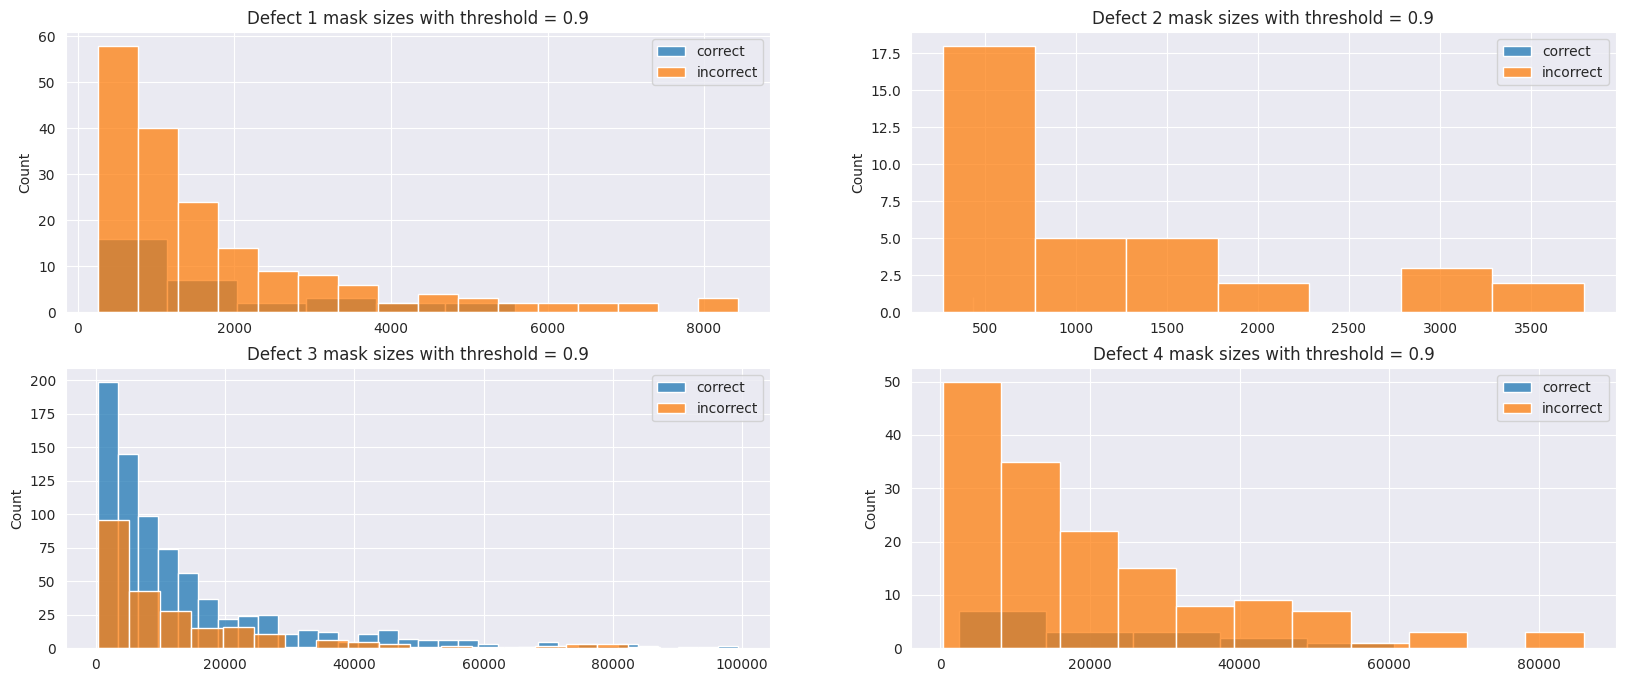

With threshold = 0.9 , defect 1 has 32 correct and 179 incorrect masks
With threshold = 0.9 , defect 2 has 1 correct and 35 incorrect masks
With threshold = 0.9 , defect 3 has 809 correct and 243 incorrect masks
With threshold = 0.9 , defect 4 has 17 correct and 156 incorrect masks



In [18]:
# PLOT RESULTS

pix_min = 250
for THRESHOLD in [0.1, 0.25, 0.50, 0.75, 0.9]:
    print('######################################')
    print('## Threshold =',THRESHOLD,'displayed below ##')
    print('######################################')
    correct=[[],[],[],[]]; incorrect=[[],[],[],[]]
    for i,f in enumerate(train2.iloc[idx:idx+len(preds)]['ImageId']):
        preds2 = preds[i].copy()
        preds2[preds2>=THRESHOLD]=1
        preds2[preds2<THRESHOLD]=0
        sums = np.sum(preds2,axis=(0,1))
        for j in range(4):
            if 4*sums[j]<pix_min: continue
            if train2.iloc[i,j+1]=='': incorrect[j].append(4*sums[j])
            else: correct[j].append(4*sums[j])
    plt.figure(figsize=(20,8))
    for j in range(4):
        limit = [10000,10000,100000,100000][j]
        plt.subplot(2,2,j+1)
        sns.histplot([x for x in correct[j] if x<limit], label = 'correct')
        sns.histplot([x for x in incorrect[j] if x<limit], label = 'incorrect')
        plt.title('Defect '+str(j+1)+' mask sizes with threshold = '+str(THRESHOLD)); plt.legend()
    plt.show()
    for j in range(4):
        c1 = np.array(correct[j])
        c2 = np.array(incorrect[j])
        print('With threshold =',THRESHOLD,', defect',j+1,'has',len(c1[c1!=0]),'correct and',len(c2[c2!=0]),'incorrect masks')
    print()

In [19]:
# SAVE MODEL
model.save(G.model_path,overwrite=True)

### Prediction EDA <a class="anchor" id="pred_eda"></a>

In [20]:
# LOAD MODEL
model = load_model(G.model_path,custom_objects={
        'dice_coef':dice_coef})
model.summary()
test = pd.read_csv(G.path + '/sample_submission.csv')

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ data (InputLayer)   │ (None, 128, 800,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_data             │ (None, 128, 800,  │          9 │ data[0][0]        │
│ (BatchNormalizatio… │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 134, 806,  │          0 │ bn_data[0][0]     │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv0 (Conv2D)      │ (None, 64, 400,   │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn0                 │ (None, 64, 400,   │        256 │ conv0[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relu0 (Activation)  │ (None, 64, 400,   │          0 │ bn0[0][0]         │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 66, 402,   │          0 │ relu0[0][0]       │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pooling0            │ (None, 32, 200,   │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn1    │ (None, 32, 200,   │        256 │ pooling0[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu1  │ (None, 32, 200,   │          0 │ stage1_unit1_bn1… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_conv1  │ (None, 32, 200,   │      4,096 │ stage1_unit1_rel… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn2    │ (None, 32, 200,   │        256 │ stage1_unit1_con… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu2  │ (None, 32, 200,   │          0 │ stage1_unit1_bn2… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_2    │ (None, 34, 202,   │          0 │ stage1_unit1_rel… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_conv2  │ (None, 32, 200,   │     36,864 │ zero_padding2d_2… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn3    │ (None, 32, 200,   │        256 │ stage1_unit1_con… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu3  │ (None, 32, 200,   │          0 │ stage1_unit1_bn3

 Total params: 97,589,533 (372.27 MB)

 Trainable params: 32,513,991 (124.03 MB)

 Non-trainable params: 47,558 (185.77 KB)

 Optimizer params: 65,027,984 (248.06 MB)

In [25]:
defect: list[str] = test.sample(16).index
test_batches = DataGenerator(test[test.index.isin(defect)],subset='test',
                                  preprocess=G.preprocess_input)

preds = model.predict(test_batches,steps=2,verbose=0)

2024-11-13 14:23:04.060578: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


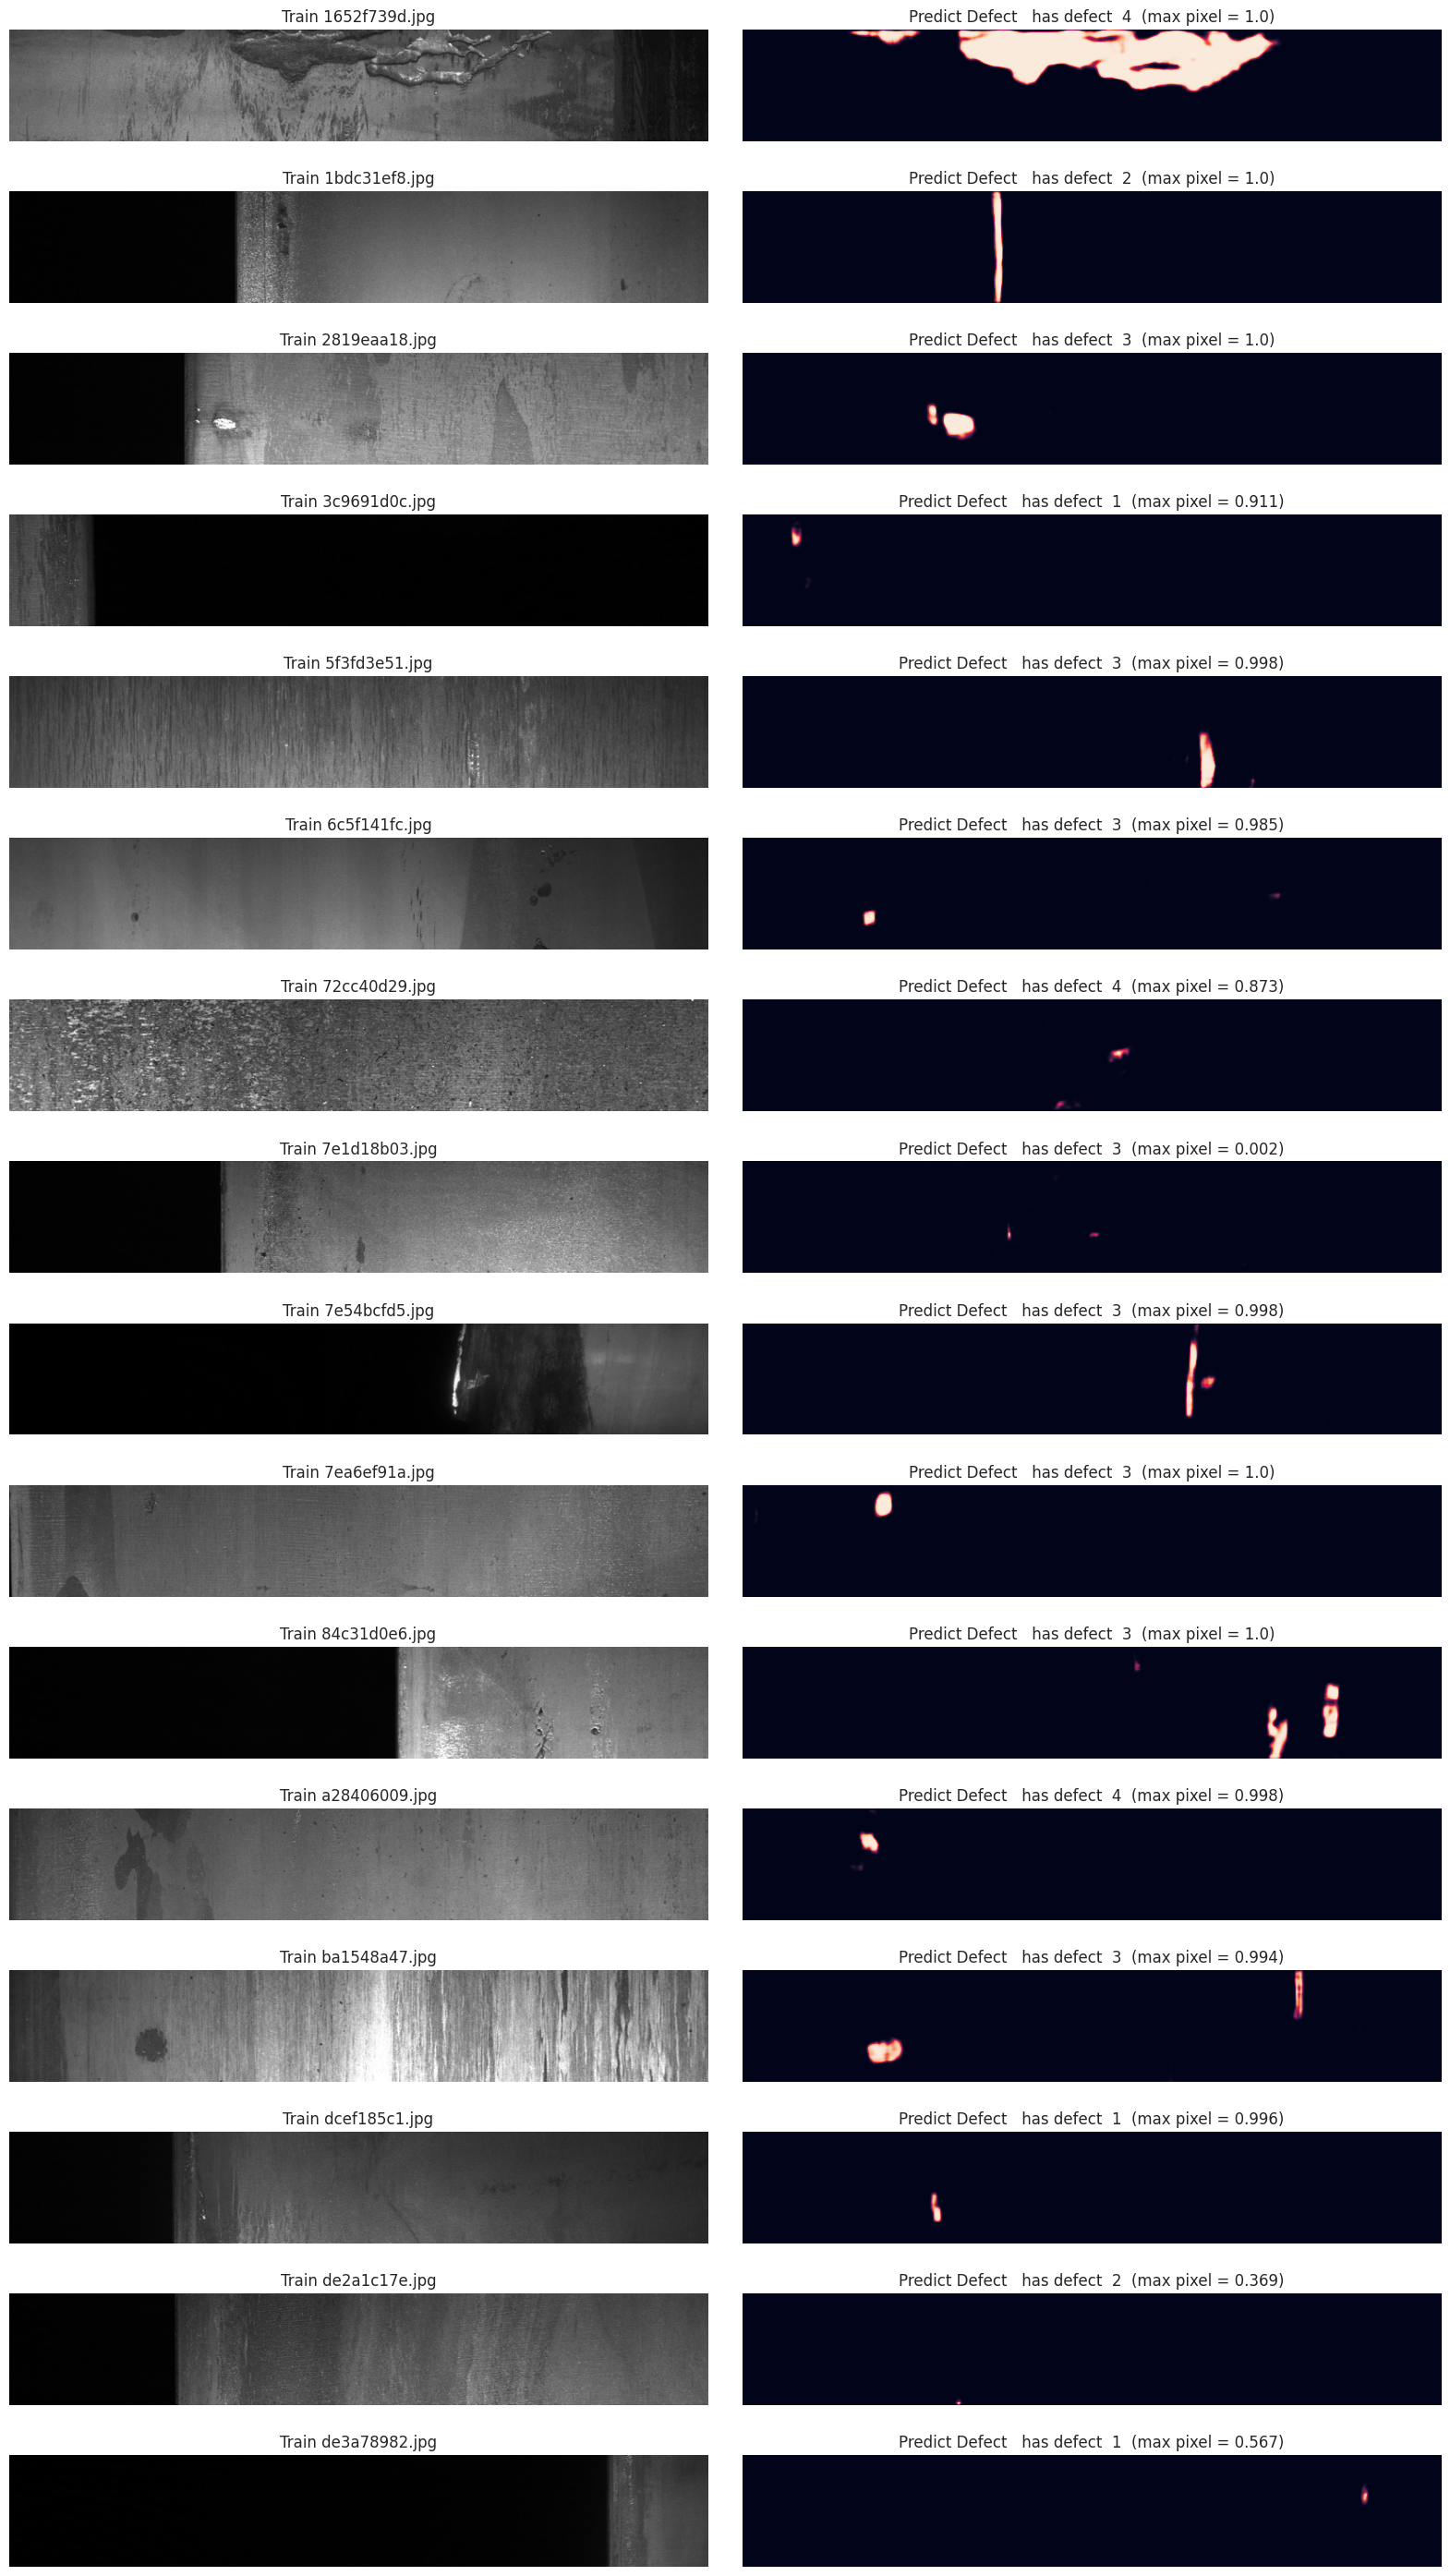

In [26]:
for i, batch in enumerate(test_batches):
    if i != 0: break
    plt.figure(figsize=(20, 36))
    for k in range(16):
        plt.subplot(16, 2, 2 * k + 1)
        img = batch[0][k,]
        img = Image.fromarray(img.astype('uint8'))
        img = np.array(img)
        dft = 0
        extra = '  has defect '
        msk_max = max([np.sum(preds[k, :, :, j]) for j in range(4)])
        for j in range(4):
            msk = preds[k, :, :, j]
            if np.sum(msk) == msk_max:
               dft = j + 1
               extra += ' ' + str(j + 1)
        if extra == '  has defect ': extra = ''
        plt.title('Train ' + test_batches.df.iloc[k, 0] )
        plt.axis('off')
        plt.imshow(img)
        plt.subplot(16, 2, 2 * k + 2)
        if dft != 0 :
            msk = preds[i + k, :, :, dft - 1]
            plt.imshow(msk)
        else:
            plt.imshow(np.zeros((128, 800)))
        plt.axis('off')
        mx = np.round(np.max(msk), 3)
        plt.title('Predict Defect ' +  extra +'  (max pixel = ' + str(
            mx) + ')')
    plt.subplots_adjust(wspace=0.05)
    plt.show()